# Faostat
The Food and Agriculture Organization of the United Nation ([FAO](https://www.fao.org/faostat/en/#data/RL)) collects data about the production of food worldwide. The data is published and made available through the [Faostat](https://www.fao.org/faostat/en/#home) webservice. Among the different datasets available, there are the Crops and livestock products dataset and the Land Use and Land Cover datasets. The monitoring of food production and of the area dedicated or available worldwide is one of the main task of the FAO. The future food availability can be forecast from this statistical data and additional data of weather forecast and climate. The data is provided by country or by region. The data about land use and production is collected annualy through questionnaire. The data about land cover is derived from remote sensing products from NASA (MODIS) and ESA (Copernicus Climate Change Service) and the maps are available from the Climate Change Initiative - Land Cover ([CCI-LC](https://maps.elie.ucl.ac.be/CCI/viewer/)) website, an outcome of the [ESA Land Cover project](https://climate.esa.int/en/projects/land-cover/). 

## The datasets
We use this notebook to download several datasets about crop production and fertilizers in some continental regions from the [Faostat webservice](https://www.fao.org/faostat/en/#home) and finally to plot the datasets for a first qualitative analysis. The crop types are: wheat, maize, rice, and soybean. The fertilizers are manure and synthetic fertilizers such as nitrogen, phosphate and potash.
### Crops
In order to download the crop datasets we have to open the Faostat webpage, select the "Production" domain, then "Crops and livestock products. From the webpage we can filter the data by region, e.g. "World (Total)", by items, e.g. "Wheat", by elements, e.g. "Yield", and finally the years, e.g. from 1961 to 2022. 
### Fertilizers
The data about the fertilizers are under the "Land, Inputs and Sustainability" domain. For the synthetic fertilizers we select the "Input" subdomain, then "Fertilizer by Nutrient". From the webpage we select the same region as for the crops, "World (Total)", the three items "Nutrient nitrogen N (total)", and also phosphate P205 (total) and potash K20 (total), and as elements "Agricultural Use". For the manure we select "Livestock Manure" from Inputs, then from from the webpage again the same region "World (Total)", element "Manure applied to soil (N content), items aggragated "All Animals (Total)".
### Temperature change on land
The temperature change is available from the same "Land, Inputs and Sustainability" domain, subdomain "Climate Change Indicators". From the webpage we select the same region, the element "Temperature change" and item "Meteorological year" from 1961 to 2022. Another source of global temperature anomalies is the Goddard Institute for Space Studies ([GISS](https://data.giss.nasa.gov/gistemp/))
### Precipitation and CO2
Precipitation and CO2 are not provided by FAO.

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import dates
import matplotlib.dates as mdates
from osgeo import gdal, osr, ogr
import geopandas as gpd
from shapely.geometry import Point
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("Python version: %s"%python_version())
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print('GDAL version: %s'%gdal.__version__)
print("GeoPandas version: %s"%gpd.__version__)

Python version: 3.11.5
NumPy version: 1.25.2
Pandas version: 2.1.1
GDAL version: 3.7.2
GeoPandas version: 0.14.0


## World maize and millet yield
We download the data about the yield of maize and millet produced in the world from 1961 up to 2022. The dataset represents a time series. A visualization of the time series will allows us to see from a qualitative point of view whether there is a trend in the yield of these two important crops. From the Faostat website we select the [Crops and livestock products](https://www.fao.org/faostat/en/#data/QCL) dataset, and in particular the World region, the yield variable, the items maize (corn) and millet, and all the years. We download and store the CSV file.  

In [77]:
#path_fao_dataset = 'data/FAOSTAT_maize_millet_world_yeld.csv'
path_fao_dataset = 'data/FAOSTAT_maize_millet_wheat_rice_soyabean.csv'
maize_millet_yield_tmp_df = pd.read_csv(path_fao_dataset)
maize_millet_yield_tmp_df.head(3)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,1,World,5419,Yield,112,Maize (corn),1961,1961,100 g/ha,19423,E,Estimated value,NaN
1,QCL,Crops and livestock products,1,World,5419,Yield,112,Maize (corn),1962,1962,100 g/ha,19796,E,Estimated value,NaN
2,QCL,Crops and livestock products,1,World,5419,Yield,112,Maize (corn),1963,1963,100 g/ha,20311,A,Official figure,NaN


We select the data for the maize yeld

In [78]:
maize_yield_df = maize_millet_yield_tmp_df[maize_millet_yield_tmp_df['Item']=='Maize (corn)'][['Year', 'Value']]
maize_yield_df.rename(columns={'Value':'Yield (100g/ha)'}, inplace=True)
maize_yield_df.head(3)

,Year,Yield (100g/ha)
0,1961,19423
1,1962,19796
2,1963,20311


and for the millet

In [79]:
millet_yield_df = maize_millet_yield_tmp_df[maize_millet_yield_tmp_df['Item']=='Millet'][['Year', 'Value']]
millet_yield_df.rename(columns={'Value':'Yield (100g/ha)'}, inplace=True)
millet_yield_df.head(2)

,Year,Yield (100g/ha)
62,1961,5925
63,1962,5619


We set the year as index

In [80]:
year_index = pd.date_range('1961', '2023', freq='Y')
maize_yield_df.set_index(year_index, inplace=True)
maize_yield_df.drop('Year', axis=1, inplace=True)
maize_yield_df.head(3)

,Yield (100g/ha)
1961-12-31,19423
1962-12-31,19796
1963-12-31,20311


In [81]:
millet_yield_df.set_index(year_index, inplace=True)
millet_yield_df.drop('Year', axis=1, inplace=True)
millet_yield_df.head(3)

,Yield (100g/ha)
1961-12-31,5925
1962-12-31,5619
1963-12-31,5717


Now we can plot the time series for maize and millet yields

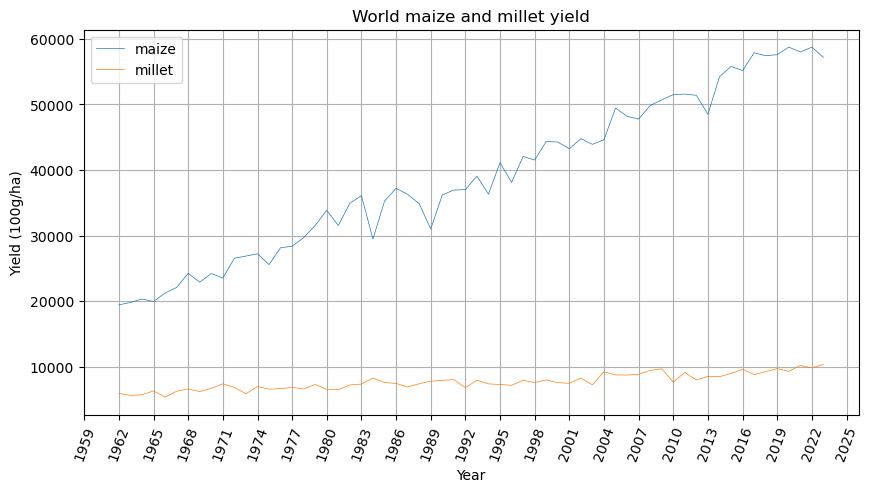

In [82]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('World maize and millet yield')
ax.set_xlabel('Year')
ax.set_ylabel('Yield (100g/ha)')
ax.set_xticks(maize_yield_df.index)
ax.set_xticklabels(maize_yield_df.index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_maize = ax.plot(maize_yield_df, linewidth=0.5, label='maize')
plt_millet = ax.plot(millet_yield_df, linewidth=0.5, label='millet')
plt.legend(loc='upper left')

## Global temperature anomalies
We use the a linear model of the maize yield to assess the impact of temperature anomalies and fertilizer. We download the annual mean temperature anomalies and the standard deviation from Faostat.

In [32]:
path_temperature_dataset = 'data/FAOSTAT_Annual_temperature_change_on_land.csv'
temperature_tmp_df = pd.read_csv(path_temperature_dataset)
temperature_tmp_df.head(2)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Months,Year Code,Year,Unit,Value,Flag,Flag Description
0,ET,Temperature change on land,1,World,7271,Temperature change,7020,Meteorological year,1961,1961,°c,0.211,E,Estimated value
1,ET,Temperature change on land,1,World,7271,Temperature change,7020,Meteorological year,1962,1962,°c,0.038,E,Estimated value


In [33]:
temperature_df = temperature_tmp_df[temperature_tmp_df['Element'] == 'Temperature change'][['Year', 'Value']]
temperature_df.tail(2)

,Year,Value
60,2021,1.447
61,2022,1.394


In [34]:
temperature_df.set_index(year_index, inplace=True)
temperature_df.drop('Year', axis=1, inplace=True)
temperature_df.head(3)

,Value
1961-12-31,0.211
1962-12-31,0.038
1963-12-31,0.168


The standard deviation has a constant value of 0.202 °C

In [46]:
std_temp_df = temperature_tmp_df[temperature_tmp_df['Element'] == 'Standard Deviation'][['Year', 'Value']]
len(std_temp_df[std_temp_df['Value'] != 0.202]) > 0

False

In [47]:
std_temp_df.set_index(year_index, inplace=True)
std_temp_df.drop('Year', axis=1, inplace=True)
std_temp_df.head(2)

,Value
1961-12-31,0.202
1962-12-31,0.202


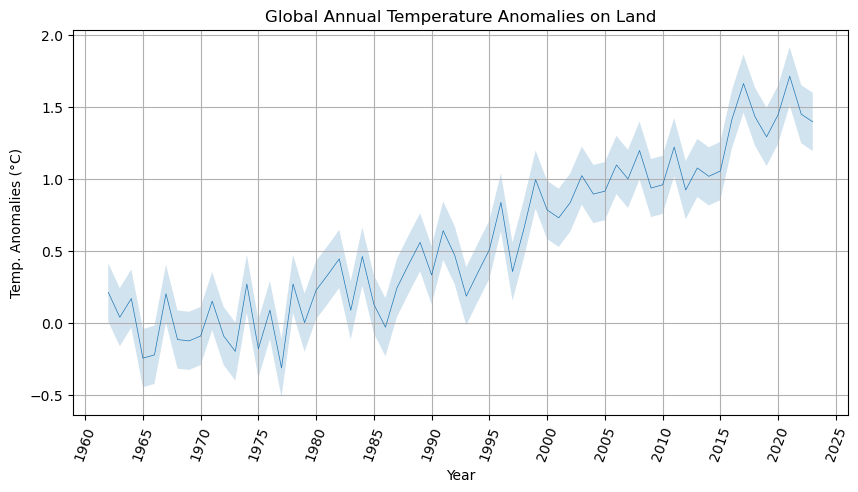

In [74]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Global Annual Temperature Anomalies on Land')
ax.set_ylabel('Temp. Anomalies (°C)')
ax.set_xlabel('Year')
ax.set_xticks(year_index)
ax.set_xticklabels(year_index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_temp = ax.plot(temperature_df['Value'], linewidth=0.5, label='Temp. Anom.')
plt_giss_error = ax.fill_between(year_index, temperature_df['Value'] - std_temp_df['Value'], \
                                 temperature_df['Value'] + std_temp_df['Value'], alpha=0.2)


## Global precipitation anomalies
The data for global precipitation anomalies are available from the United States Environmental Protection Agency ([EPA](https://www.epa.gov/climate-indicators/climate-change-indicators-us-and-global-precipitation)) website. The values are in inch and will be transformed in mm.

In [159]:
path_precipitation_dataset = 'data/US_EPA_precipitation_fig-2.csv'
precipitation_full_df = pd.read_csv(path_precipitation_dataset, skiprows=6)
precipitation_full_df.head(2)

,Year,Anomaly
0,1901,-0.375634
1,1902,-0.585870


In [160]:
precipitation_full_df.set_index(pd.date_range('1901', '2022', freq='Y'), inplace=True)
precipitation_full_df.drop('Year', axis=1, inplace=True)
precipitation_full_df.head(2)

,Anomaly
1901-12-31,-0.375634
1902-12-31,-0.585870


We multiply the precipitation values in inch by a constant to transform them in mm.

In [165]:
precipitation_df = precipitation_full_df['1961':] * 25.4
precipitation_df.head(2)

,Anomaly
1961-12-31,15.318908
1962-12-31,0.768900


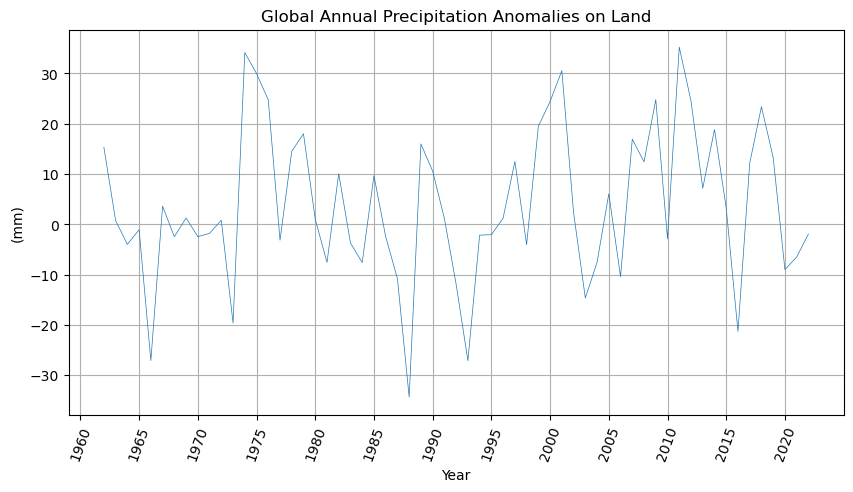

In [166]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Global Annual Precipitation Anomalies on Land')
ax.set_ylabel('(mm)')
ax.set_xlabel('Year')
ax.set_xticks(year_index)
ax.set_xticklabels(year_index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_precipitation = ax.plot(precipitation_df, linewidth=0.5, label='Precipitation. Anom.')

## Fertilizers
We download from the Faostat website the dataset of the amount of livestock manure applied to soil. 

### Manure

In [70]:
path_manure_dataset = 'data/FAOSTAT_Livestock_manure.csv'
manure_df = pd.read_csv(path_manure_dataset, usecols=['Year', 'Value'])
manure_df.tail(2)

,Year,Value
59,2020,2.731401e+10
60,2021,2.745751e+10


In [71]:
manure_df.set_index(year_index[:-1], inplace=True)
manure_df.drop('Year', axis=1, inplace=True)
manure_df.tail(3)

,Value
2019-12-31,2.686690e+10
2020-12-31,2.731401e+10
2021-12-31,2.745751e+10


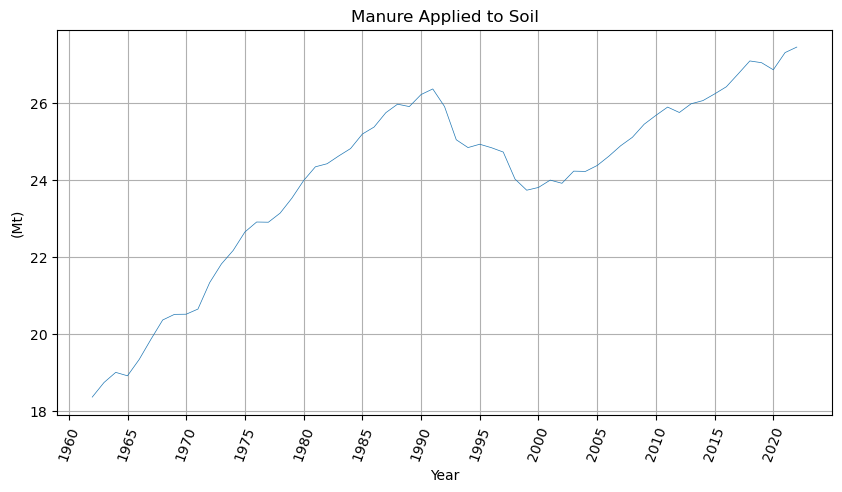

In [83]:
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Manure Applied to Soil')
ax.set_ylabel('(Mt)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.set_xlabel('Year')
ax.set_xticks(year_index)
ax.set_xticklabels(year_index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_temp = ax.plot(manure_df / 10**9, linewidth=0.5, label='Manure.')
#plt.legend(loc='upper left')

### Nitrogen, phosphate, and potash
We download the dataset for the three synthetic fertilizers: nitrogen, phosphate P205, and potash.

In [86]:
path_fertilizers_dataset = 'data/FAOSTAT_synthetic_fertilizers.csv'
fertilizers_df = pd.read_csv(path_fertilizers_dataset)
fertilizers_df.tail(2)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
181,RFN,Fertilizers by Nutrient,1,World,5157,Agricultural Use,3104,Nutrient potash K2O (total),2020,2020,t,39024540.40,E,Estimated value,NaN
182,RFN,Fertilizers by Nutrient,1,World,5157,Agricultural Use,3104,Nutrient potash K2O (total),2021,2021,t,40128174.45,E,Estimated value,NaN


In [92]:
nitrogen_df = fertilizers_df[fertilizers_df['Item']=='Nutrient nitrogen N (total)'][['Year', 'Value']]
nitrogen_df.rename(columns={'Value':'Nitrogen (tons)'}, inplace=True)
nitrogen_df.head(3)

,Year,Nitrogen (tons)
0,1961,11486265.27
1,1962,12969831.11
2,1963,14632762.48


In [93]:
year_index = pd.date_range('1961', '2022', freq='Y')
nitrogen_df.set_index(year_index, inplace=True)
nitrogen_df.drop('Year', axis=1, inplace=True)
nitrogen_df.tail(2)

,Nitrogen (tons)
2020-12-31,1.105417e+08
2021-12-31,1.086882e+08


In [88]:
phosphate_df = fertilizers_df[fertilizers_df['Item']=='Nutrient phosphate P2O5 (total)'][['Year', 'Value']]
phosphate_df.rename(columns={'Value':'Phosphate (tons)'}, inplace=True)
phosphate_df.head(3)

,Year,Phosphate (tons)
61,1961,10888968.81
62,1962,11534554.43
63,1963,12833399.67


In [94]:
phosphate_df.set_index(year_index, inplace=True)
phosphate_df.drop('Year', axis=1, inplace=True)
phosphate_df.tail(2)

,Phosphate (tons)
2020-12-31,48364923.38
2021-12-31,46269708.33


In [89]:
potash_df = fertilizers_df[fertilizers_df['Item']=='Nutrient potash K2O (total)'][['Year', 'Value']]
potash_df.rename(columns={'Value':'Potash (tons)'}, inplace=True)
potash_df.head(3)

,Year,Potash (tons)
122,1961,8626724.57
123,1962,9146891.38
124,1963,9917337.39


In [95]:
potash_df.set_index(year_index, inplace=True)
potash_df.drop('Year', axis=1, inplace=True)
potash_df.tail(2)

,Potash (tons)
2020-12-31,39024540.40
2021-12-31,40128174.45


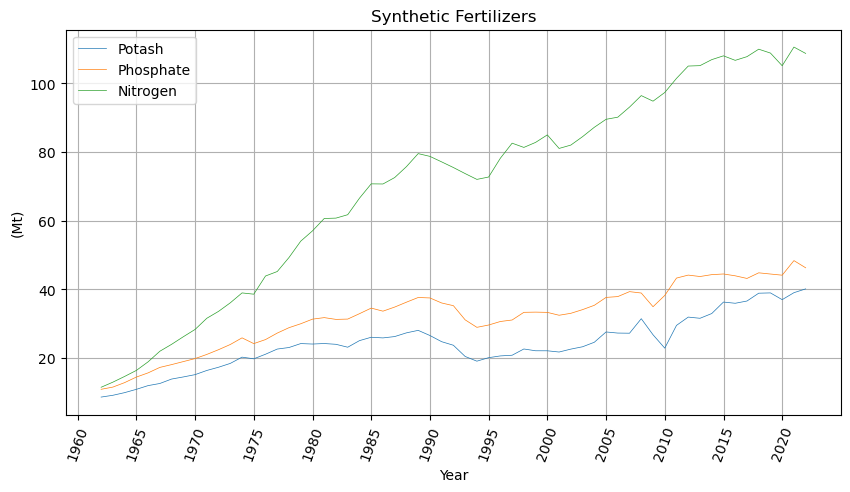

In [102]:
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Synthetic Fertilizers')
ax.set_ylabel('(Mt)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlabel('Year')
ax.set_xticks(year_index)
ax.set_xticklabels(year_index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_potash = ax.plot(potash_df / 10**6, linewidth=0.5, label='Potash')
plt_phosphate = ax.plot(phosphate_df / 10**6, linewidth=0.5, label='Phosphate')
plt_nitrogen = ax.plot(nitrogen_df / 10**6, linewidth=0.5, label='Nitrogen')
plt.legend(loc='upper left')

## Moving window mean
We compute the moving window mean for every decade

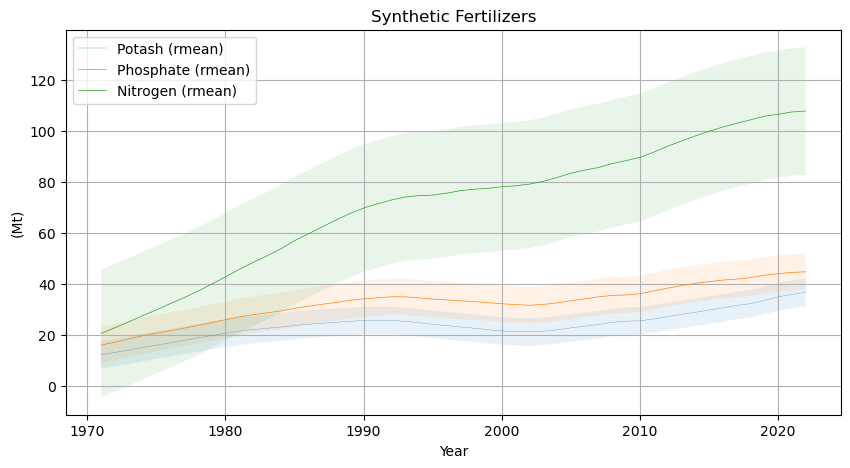

In [192]:
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
window = 10
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Synthetic Fertilizers')
ax.set_ylabel('(Mt)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlabel('Year')
ax.set_xticks(year_index)
ax.set_xticklabels(year_index, rotation=0)
ax.xaxis.set_major_locator(dates.YearLocator(window))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

potash_rmean = potash_df.rolling(window).mean().dropna()
potash_std = potash_rmean.std()
potash_low = potash_rmean - potash_std
potash_up = potash_rmean + potash_std
plt_potash_rmean = ax.plot(potash_rmean / 10**6, linewidth=0.2, label='Potash (rmean)')
plt_potash_error = ax.fill_between(potash_rmean.index, potash_low['Potash (tons)'] / 10**6, potash_up['Potash (tons)'] / 10**6, alpha=0.1)

phosphate_rmean = phosphate_df.rolling(window).mean().dropna()
phosphate_std = phosphate_rmean.std()
phosphate_low = phosphate_rmean - phosphate_std
phosphate_up = phosphate_rmean + phosphate_std
plt_phosphate_rmean = ax.plot(phosphate_rmean / 10**6, linewidth=0.5, label='Phosphate (rmean)')
plt_phosphate_error = ax.fill_between(phosphate_rmean.index, phosphate_low['Phosphate (tons)'] / 10**6, phosphate_up['Phosphate (tons)'] / 10**6, alpha=0.1)

nitrogen_rmean = nitrogen_df.rolling(window).mean().dropna()
nitrogen_std = nitrogen_rmean.dropna().std()
nitrogen_low = nitrogen_rmean - nitrogen_std
nitrogen_up = nitrogen_rmean + nitrogen_std
plt_nitrogen_rmean = ax.plot(nitrogen_rmean / 10**6, linewidth=0.5, label='Nitrogen (rmean)')
plt_nitrogen_error = ax.fill_between(nitrogen_rmean.index, nitrogen_low['Nitrogen (tons)'] / 10**6, nitrogen_up['Nitrogen (tons)'] / 10**6, alpha=0.1)

plt.legend(loc='upper left')

## The SARIMAX model
We use a model for the maize yield that takes into account some past values of yield and errors and also the temperature anomalies and fertilizers, that is we assume that temperature anomalies and the amount of fertilizers are good predictors of the maize yield. If we represent by $y_t$ the present value of the maize yeld its dependency can be represented as

$$y_t = SARIMA(p,d,q)(P,D,Q)m + \beta_1 T_t + \beta_2 F_t$$

where $T_t$ is the present temperature anomaly, $F_t$ the present amount of fertilizers, and the other parameters have the following interpretation: p is number of past y values, d the difference order, q the number of previous errors, P and Q the past values and errors respectively of the seasonality and m its frequency. 

### Stationarity
We check whether the maize yield time series is stationary. The nulll hypothesis is that it is not stationary and, from the result of the augmented Dickey-Fuller test, it cannot be rejected.

In [17]:
maize_yield_df['Yield (g/ha)']

1961-12-31    19423
1962-12-31    19796
1963-12-31    20311
1964-12-31    19937
1965-12-31    21237
              ...  
2018-12-31    57583
2019-12-31    58744
2020-12-31    57998
2021-12-31    58728
2022-12-31    57183
Freq: A-DEC, Name: Yield (g/ha), Length: 62, dtype: int64

The result of the ADF test, small negative number and p-value > 0.05 means that we cannot reject the null hypothesis and the maize yield series is not stationary. 

In [18]:
ADF_result = adfuller(maize_yield_df)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.3257226813405258
p-value: 0.9217813968357452


We compute the first order difference of the maize yield and apply again the ADF test

In [22]:
maize_yield_diff = np.diff(maize_yield_df['Yield (g/ha)'], n=1)
maize_yield_diff_df = pd.DataFrame({'Diff': maize_yield_diff}, index=year_index[1:])

The first order difference of the maize yield is stationary so we can set the difference order for the SARIMAX model to d=1

In [23]:
ADF_result = adfuller(maize_yield_diff_df)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.53292318437123
p-value: 9.767874162294072e-09


We define a function to train the SARIMAX model using different combination of its input parameters p, P, q, and Q and to rank the results according to the Akaike Information Criterion (AIC). 

In [24]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

We test different combinations of values for the parameters p, q, P, and Q. 

In [74]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
Q = range(0, 4, 1)

In [42]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

We create the training sets for the [SARIMAX](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) model using the endogenous data, i.e. maize, and the exogenous data, temperature anomalies and fertilizer. Note that the values for the maize yield, the temperature anomalies, and the manure differ for 10 orderd of magnitude. Probably we have to re-scale these values before using them to train the SARIMAX model. 

In [86]:
index = pd.date_range('1961', '2021', freq='Y')
train_endog = millet_yield_df['1961':'2020']
temperature = temperature_df['Value']['1961':'2020']
manure = manure_df['Value']['1961':'2020']
train_exog = pd.DataFrame({'Anomalies': temperature, 'Manure': manure}, index=index)
train_exog.head(2)

,Anomalies,Manure
1961-12-31,0.211,1.835092e+10
1962-12-31,0.038,1.872918e+10


In [91]:
result_df = optimize_SARIMAX(train_endog, train_exog, parameters_list, d, D, s)
result_df.head(3)

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(0, 1, 0, 0)",1469.556239
1,"(1, 1, 0, 0)",1472.581327
2,"(0, 2, 0, 0)",1473.349380


We train the SARIMAX model using the values of its parameters that returned the best model (lowest AIC). We can see from the results that the p-value for both manure and temperature anomalies is lower than 0.05. The coefficient for manure is very small 

In [75]:
p = 0
q = 1
P = 0
Q = 0
D = 0
s = 0
best_model = SARIMAX(train_endog, train_exog, order=(p,d,q), seasonal_order=(P,D,Q,s), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           Yield (g/ha)   No. Observations:                   60
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -730.778
Date:                Wed, 24 Jan 2024   AIC                           1469.556
Time:                        13:22:08   BIC                           1477.866
Sample:                    12-31-1961   HQIC                          1472.800
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Anomalies   3.273e+04   2.49e-08   1.31e+12      0.000    3.27e+04    3.27e+04
Manure      2.209e-05   6.46e-06      3.418      0.001    9.43e-06    3.48e-05
ma.L1         -0.6842      0.111     -6.169      0.0

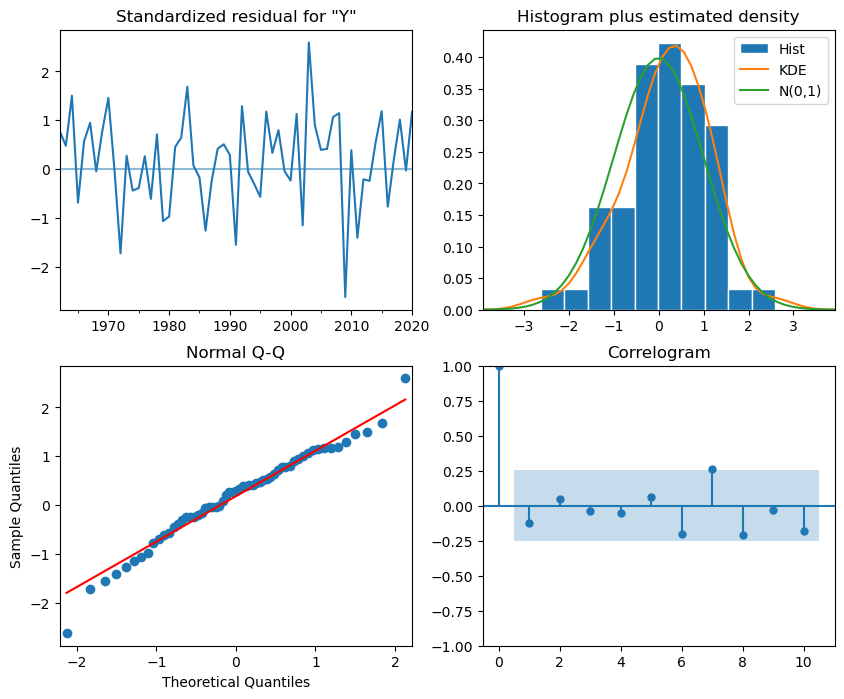

In [77]:
best_model_fit.plot_diagnostics(figsize=(10,8));

In [78]:
residuals = best_model_fit.resid
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(pvalue)

lb_pvalue


In [82]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(0,1,1), seasonal_order=(0,0,0,0), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [130]:
target_train = maize_yield_df['Yield (g/ha)'][:'2017']
target_test = maize_yield_df['Yield (g/ha)']['2017':]
pred_df = pd.DataFrame({'actual': target_test})
TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
print('Number of training records for maize: {0:d}\nHorizon: {1:d}'.format(TRAIN_LEN, HORIZON))

Number of training records for maize: 57
Horizon: 6


In [131]:
WINDOW = 1
pred_last_value = recursive_forecast(target_train, train_exog[:'2017'], TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target_train, train_exog[:'2017'], TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

In [133]:
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX
pred_df

,actual,pred_last_value,pred_SARIMAX
2017-12-31,57425,57425,57450.251065
2018-12-31,57583,57425,57450.251065
2019-12-31,58744,57425,57450.251065
2020-12-31,57998,57425,57450.251065
2021-12-31,58728,57425,57450.251065
2022-12-31,57183,57425,57450.251065


We compute the mean absolute percentage error (MAPE) for the two prediction methods

In [134]:
def mape(y_obs, y_pred):
    return np.mean(np.abs((y_obs - y_pred) / y_obs)) * 100

In [145]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)
print(mape_last, mape_SARIMAX)

1.0249322013090163 1.0107254704158797


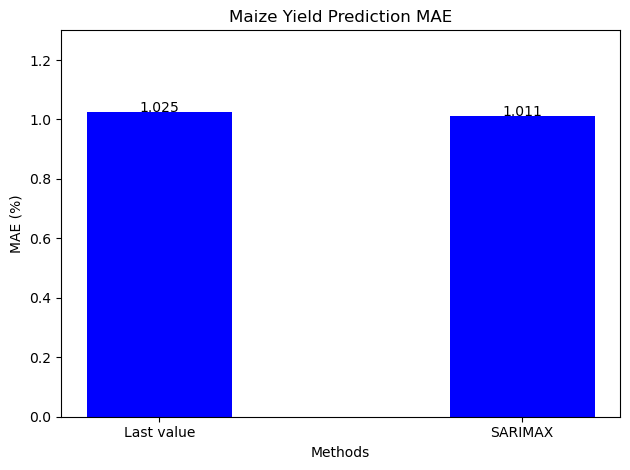

In [148]:
fig, ax = plt.subplots()
x = ['Last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]
ax.bar(x, y, width=0.4, color='blue')
ax.set_title('Maize Yield Prediction MAE')
ax.set_xlabel('Methods')
ax.set_ylabel('MAE (%)')
ax.set_ylim(0, 1.3)
for index, value in enumerate(y):
    plt.text(x=index, y = value + 0.001, s=str(round(value, 3)), ha='center')
plt.tight_layout()

In [154]:
maize_yield_df['Prediction (SARIMAX)'] = pd.Series()
maize_yield_df['Prediction (SARIMAX)']['2017':] = pred_SARIMAX
maize_yield_df['Prediction (Last value)'] = pd.Series()
maize_yield_df['Prediction (Last value)']['2017':] = pred_last_value
maize_yield_df['2017':]

,Yield (g/ha),Prediction (SARIMAX),Prediction (Last value)
2017-12-31,57425,57450.251065,57425
2018-12-31,57583,57450.251065,57425
2019-12-31,58744,57450.251065,57425
2020-12-31,57998,57450.251065,57425
2021-12-31,58728,57450.251065,57425
2022-12-31,57183,57450.251065,57425


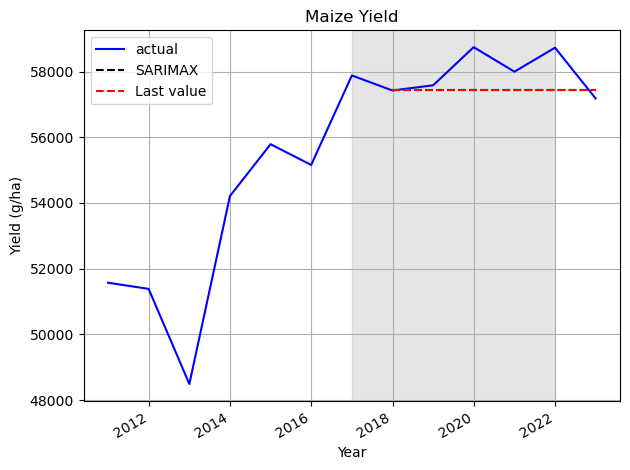

In [162]:
fig, ax = plt.subplots()
ax.plot(maize_yield_df['Yield (g/ha)']['2010':], 'b-', label='actual')
ax.plot(maize_yield_df['Prediction (SARIMAX)']['2010':], 'k--', label='SARIMAX')
ax.plot(maize_yield_df['Prediction (Last value)']['2010':], 'r--', label='Last value')
ax.grid(True)
ax.set_title('Maize Yield')
ax.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Yield (g/ha)')
ax.axvspan('2017', '2022', color='#808080', alpha=0.2)
fig.autofmt_xdate()
plt.tight_layout()

## References
* [FAO Land Statistics](https://www.fao.org/3/cb2860en/cb2860en.pdf)